In [1]:
from __future__ import print_function

import torch
import torchvision
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision import transforms

from torch import nn, optim
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import math

In [2]:
# params
BATCH_SIZE = 64
EPOCHS = 30

In [3]:
# data preparations
trans_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = MNIST('data', train=True, download=True, transform=trans_img)
testset = MNIST('data', train=False, download=True, transform=trans_img)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=2)

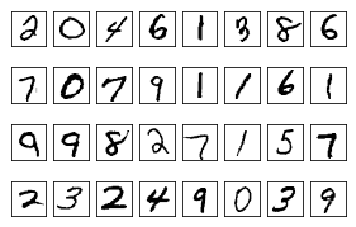

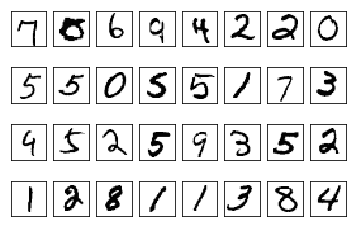

In [4]:
# visualize images
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
cnt = 0
for (img_batch, label) in train_loader:
    cnt += 1
    if cnt > 2:
        break
    fig, ax = plt.subplots(
        nrows=4,
        ncols=8,
        sharex=True,
        sharey=True, )
    ax = ax.flatten()
    for i in range(32):
        img = img_batch[i].numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()
    plt.close()
plt.ioff()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
# training
model = Net().cuda()
learning_rate = 0.001

criterion  = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

train_losses=[]
test_losses=[]

for epoch in range(EPOCHS):
    running_loss, running_acc = 0., 0.
    for (img, label) in train_loader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predict = torch.max(output, 1)
        correct_num = (predict == label).sum()
        running_acc += correct_num.item()
        
    running_loss /= len(trainset)
    running_acc /= len(trainset)
    
    with torch.no_grad():
        test_loss, test_acc = 0., 0.
        for images, labels in test_loader:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
            output = model(images)
            loss = criterion(output, labels)

            test_loss += loss.item()
            _, predict = torch.max(output, 1)
            correct_num = (predict == labels).sum()
            test_acc += correct_num.item()
    
    test_loss /= len(testset)
    test_acc /= len(testset)
    
    train_losses.append(running_loss)
    test_losses.append(test_loss)
    print("Epoch: {}/{}.. ".format(epoch+1, EPOCHS),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accuracy: {:.3f}% ".format(100*running_acc),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}% ".format(100*test_acc))

Epoch: 1/30..  Training Loss: 0.298..  Training Accuracy: 90.645%  Test Loss: 0.105..  Test Accuracy: 96.880% 
Epoch: 2/30..  Training Loss: 0.103..  Training Accuracy: 96.985%  Test Loss: 0.081..  Test Accuracy: 97.450% 
Epoch: 3/30..  Training Loss: 0.075..  Training Accuracy: 97.733%  Test Loss: 0.071..  Test Accuracy: 97.870% 
Epoch: 4/30..  Training Loss: 0.063..  Training Accuracy: 98.030%  Test Loss: 0.061..  Test Accuracy: 98.050% 
Epoch: 5/30..  Training Loss: 0.053..  Training Accuracy: 98.378%  Test Loss: 0.063..  Test Accuracy: 98.130% 
Epoch: 6/30..  Training Loss: 0.048..  Training Accuracy: 98.458%  Test Loss: 0.060..  Test Accuracy: 98.080% 
Epoch: 7/30..  Training Loss: 0.042..  Training Accuracy: 98.693%  Test Loss: 0.055..  Test Accuracy: 98.440% 
Epoch: 8/30..  Training Loss: 0.039..  Training Accuracy: 98.805%  Test Loss: 0.056..  Test Accuracy: 98.450% 
Epoch: 9/30..  Training Loss: 0.035..  Training Accuracy: 98.893%  Test Loss: 0.066..  Test Accuracy: 98.200% 
E

In [7]:
# save the model
torch.save(model.state_dict(), 'conv.pth')

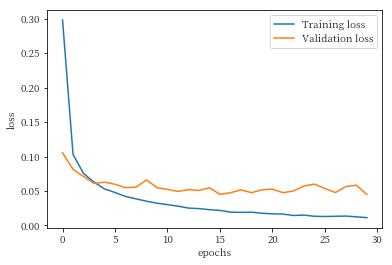

In [8]:
# evaluation
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [9]:
# user testing
mymodel = Net().cuda()
mymodel.load_state_dict(torch.load('conv.pth'))
print('testing cnn model')
with torch.no_grad():
    testloss, testacc = 0., 0.
    for (img, label) in test_loader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = mymodel(img)
        loss = criterion(out, label)
        testloss += loss.item()
        _, predict = torch.max(out, 1)
        correct_num = (predict == label).sum()
        testacc += correct_num.item()    
        
    testloss /= len(testset)
    testacc /= len(testset)
    
    print('cnn model, Test: Loss: %.5f, Acc: %.2f' % (testloss, 100 * testacc))

testing cnn model
cnn model, Test: Loss: 0.05279, Acc: 98.69
